In [1]:
### Load all Required Libraries #####
library(tidyverse)
library(GSEABase)
library(readr)
library(dplyr)
library(GSVA)
library(msigdbr)
library(tidyr)
library(pheatmap)
library(ggplot2)
library(rstatix)
library(ggpubr)
library(gridExtra)
library(ggboxplot)
library(ComplexHeatmap)
library(DESeq2)
library(umap)


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are 

ERROR: Error in library(ggboxplot): there is no package called ‘ggboxplot’


In [4]:
## Load the raw count data, as DESeq2 and other tool such as edgeR can handle raw count and kore appropriate for DGE
## The batch information we can provide while genration of contrast for DGE ###
## step 1.  Load the raw count data and first extract only protein coding genes and remove the duplicated ones if found - 
## read the dataframe and remove the first column
df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/nextflow/results_batch/star_salmon/salmon.merged.gene_counts.tsv", sep="\t", header=T, check.names=T, row.names=1)
protein_data <- read.delim("/data/kumarr9/Priya_Project/nextflow/Homo_sapiens.GRCh38.113.protein_coding.txt", header=T)
### collecting only protein coding genes from all_rna_seq data file
all_rna_seq.protein.coding <- merge(df, protein_data, by=c("gene_name"))

# First, let's see if there are any duplicates
duplicated_genes <- all_rna_seq.protein.coding$gene_name[duplicated(all_rna_seq.protein.coding$gene_name)]
print(paste("Number of duplicated genes:", length(duplicated_genes)))

# Option 1: Keep the first occurrence of each gene name
#all_rna_seq.protein.coding_unique <- all_rna_seq.protein.coding[!duplicated(all_rna_seq.protein.coding$gene_name), ]

# Option 2: If you want to aggregate duplicates by taking the mean of expression values
# (uncomment if you prefer this approach)
all_rna_seq.protein.coding_unique <- aggregate(. ~ gene_name, data = all_rna_seq.protein.coding, FUN = mean)

# Save the deduplicated data
write.table(all_rna_seq.protein.coding_unique, 
            file = "/data/kumarr9/X202SC24118381-Z01-F001/DGE/all_rna_seq.protein.coding_unique.tsv", 
            sep = "\t", 
            row.names = FALSE, 
            quote = FALSE)

# Print dimensions before and after removing duplicates
print(paste("Original dimensions:", paste(dim(all_rna_seq.protein.coding), collapse = " x ")))
print(paste("After removing duplicates:", paste(dim(all_rna_seq.protein.coding_unique), collapse = " x ")))


[1] "Number of duplicated genes: 35"
[1] "Original dimensions: 19482 x 10"
[1] "After removing duplicates: 19447 x 10"


converting counts to integer mode



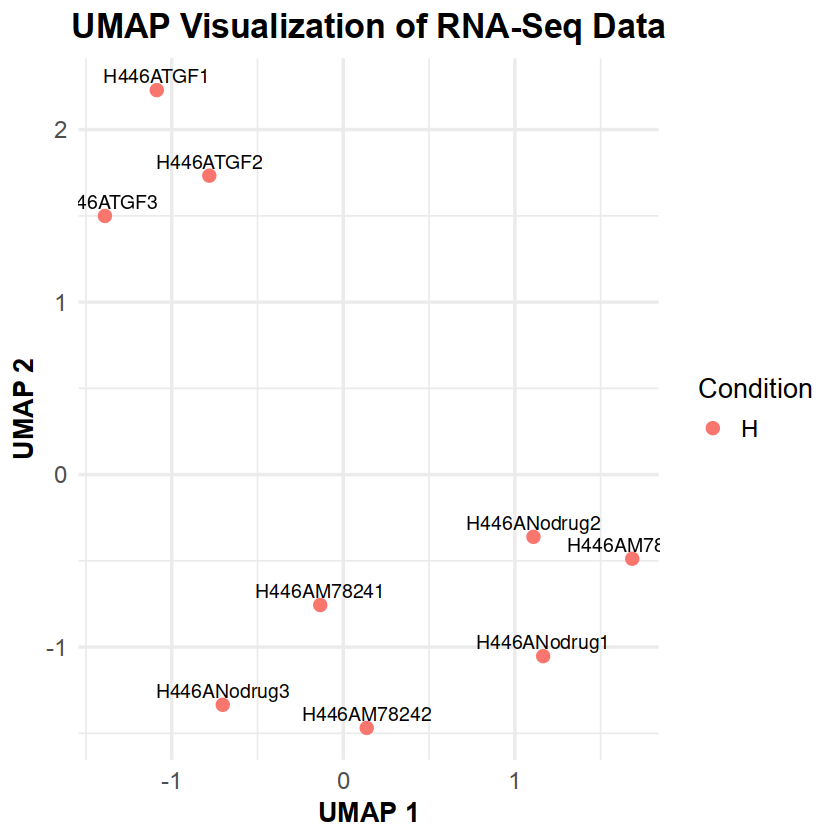

In [14]:
#### Step 2 ### The UMAP analysis 
## Load the expression dataset ####
library(ggplot2)
library(umap)

set.seed(123)

# Load count data
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)

# VST transformation
vst_counts <- varianceStabilizingTransformation(round(as.matrix(count.df)))

# Adjust UMAP parameters to fix the "number of neighbors" issue
umap_config <- umap.defaults
umap_config$n_neighbors <- min(5, ncol(vst_counts) - 1)  # Set n_neighbors smaller than the number of samples

# UMAP calculation
umap_result <- umap(t(vst_counts), config = umap_config)

# Create plotting dataframe
plot_df <- data.frame(
  UMAP1 = umap_result$layout[, 1],
  UMAP2 = umap_result$layout[, 2],
  Sample = colnames(count.df),
  Condition = sub(".*?([^0-9]+).*", "\\1", colnames(count.df))  # Extract condition from sample names
)
## Saving the dataframe UMAP 
write.table(plot_df, file="/data/kumarr9/X202SC24118381-Z01-F001/DGE/UMAP_df.tsv", row.names=T)

# Enhanced Plot
ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  geom_text(hjust = 0.5, vjust = -0.5, color = "black", size = 4) +  # Adjust label size and color
  theme_minimal(base_size = 16, base_family = "Arial") +  # Set base font size and font family
  theme(
    text = element_text(color = "black"),  # Set all text to black
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),  # Centered title with bold font
    axis.title = element_text(size = 16, face = "bold"),  # Bold axis titles
    axis.text = element_text(size = 14),  # Larger axis tick labels
    legend.title = element_text(size = 16),  # Larger legend title
    legend.text = element_text(size = 14)  # Larger legend text
  ) +
  labs(title = "UMAP Visualization of RNA-Seq Data", x = "UMAP 1", y = "UMAP 2")


Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowA

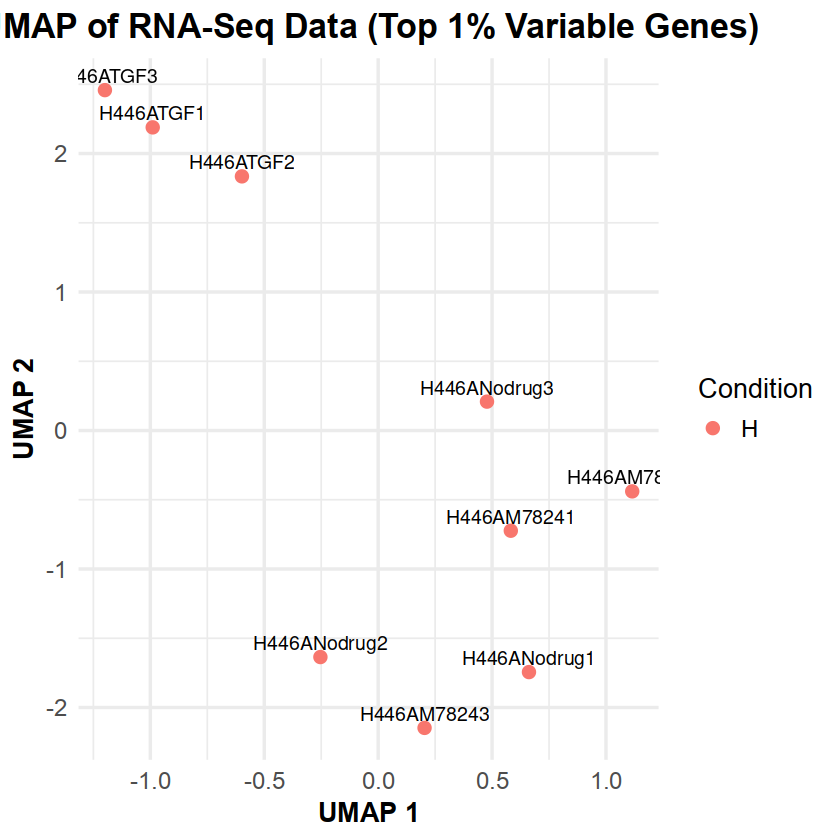

In [2]:
#### UMAP with top 1% variable genes 
library(ggplot2)
library(umap)
library(DESeq2)  # For varianceStabilizingTransformation

set.seed(123)

# Load count data
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)

# VST transformation
vst_counts <- varianceStabilizingTransformation(round(as.matrix(count.df)))

# Calculate row variances
row_vars <- apply(vst_counts, 1, var)

# Select top 1% most variable genes
top_genes <- names(sort(row_vars, decreasing = TRUE)[1:ceiling(0.01 * nrow(vst_counts))])

# Subset the data to include only the top variable genes
vst_counts_subset <- vst_counts[top_genes, ]

# Adjust UMAP parameters
umap_config <- umap.defaults
umap_config$n_neighbors <- min(5, ncol(vst_counts_subset) - 1)

# UMAP calculation with subset data
umap_result <- umap(t(vst_counts_subset), config = umap_config)

# Create plotting dataframe
plot_df <- data.frame(
  UMAP1 = umap_result$layout[, 1],
  UMAP2 = umap_result$layout[, 2],
  Sample = colnames(count.df),
  Condition = sub(".*?([^0-9]+).*", "\\1", colnames(count.df))
)

# Save the dataframe
#write.table(plot_df, file="/data/kumarr9/X202SC24118381-Z01-F001/DGE/UMAP_df_top1percent.tsv", row.names=TRUE)

# Enhanced Plot
ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  geom_text(hjust = 0.5, vjust = -0.5, color = "black", size = 4) +
  theme_minimal(base_size = 16, base_family = "Arial") +
  theme(
    text = element_text(color = "black"),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  ) +
  labs(title = "UMAP of RNA-Seq Data (Top 1% Variable Genes)", x = "UMAP 1", y = "UMAP 2")


In [4]:
##### PCA with top 1% variable genes 
library(ggplot2)
library(DESeq2)
library(factoextra)  # For PCA visualization

set.seed(123)

# Load count data
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)

# VST transformation
vst_counts <- varianceStabilizingTransformation(round(as.matrix(count.df)))

# Calculate row variances
row_vars <- apply(vst_counts, 1, var)

# Select top 1% most variable genes
top_genes <- names(sort(row_vars, decreasing = TRUE)[1:ceiling(0.01 * nrow(vst_counts))])

# Subset the data to include only the top variable genes
vst_counts_subset <- vst_counts[top_genes, ]

# Perform PCA
pca_result <- prcomp(t(vst_counts_subset), scale. = TRUE)

# Create a dataframe for plotting
pca_df <- as.data.frame(pca_result$x)
pca_df$Sample <- rownames(pca_df)

# Create a function to assign conditions
assign_condition <- function(sample_name) {
  if (grepl("H446AM7824", sample_name)) return("AM7824")
  if (grepl("H446ANodrug", sample_name)) return("No drug")
  if (grepl("H446ATGF", sample_name)) return("TGF")
  return("Unknown")
}

# Apply the function to create the Condition column
pca_df$Condition <- sapply(pca_df$Sample, assign_condition)

# Calculate the percentage of variance explained by each principal component
var_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# Save PCA results
write.table(pca_df, file="/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_df_top1percent.tsv", row.names=FALSE)

# Create PCA plot
pca_plot <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  geom_text(hjust = 0.5, vjust = -0.5, color = "black", size = 4) +
  theme_classic(base_size = 16, base_family = "Arial") +
  theme(
    text = element_text(color = "black"),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  ) +
  labs(
    title = "PCA of RNA-Seq Data (Top 1% Variable Genes)",
    x = paste0("PC1 (", round(var_explained[1], 2), "%)"),
    y = paste0("PC2 (", round(var_explained[2], 2), "%)"),
    color = "Condition"
  ) +
  scale_color_manual(values = c("AM7824" = "red", "No drug" = "blue", "TGF" = "green"))

# Save the plot
ggsave("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_plot_top1percent.tiff", pca_plot, width = 12, height = 8, dpi = 300)

# Create scree plot
scree_plot <- fviz_eig(pca_result, addlabels = TRUE, ylim = c(0, 100))

# Save the scree plot
ggsave("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_scree_plot_top1percent.tiff", scree_plot, width = 10, height = 6, dpi = 300)


converting counts to integer mode



In [5]:
####### PCA with median absolute deviation #######
##### PCA with top 1% variable genes using MAD
library(ggplot2)
library(DESeq2)
library(factoextra)  # For PCA visualization
library(matrixStats)  # For rowMads function

set.seed(123)

# Load count data
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)

# VST transformation
vst_counts <- varianceStabilizingTransformation(round(as.matrix(count.df)))

# Calculate row MADs
row_mads <- rowMads(vst_counts)

# Select top 1% most variable genes based on MAD
top_genes <- names(sort(row_mads, decreasing = TRUE)[1:ceiling(0.01 * nrow(vst_counts))])

# Subset the data to include only the top variable genes
vst_counts_subset <- vst_counts[top_genes, ]

# Perform PCA
pca_result <- prcomp(t(vst_counts_subset), scale. = TRUE)

# Create a dataframe for plotting
pca_df <- as.data.frame(pca_result$x)
pca_df$Sample <- rownames(pca_df)

# Create a function to assign conditions
assign_condition <- function(sample_name) {
  if (grepl("H446AM7824", sample_name)) return("AM7824")
  if (grepl("H446ANodrug", sample_name)) return("No drug")
  if (grepl("H446ATGF", sample_name)) return("TGF")
  return("Unknown")
}

# Apply the function to create the Condition column
pca_df$Condition <- sapply(pca_df$Sample, assign_condition)

# Calculate the percentage of variance explained by each principal component
var_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# Save PCA results
write.table(pca_df, file="/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_df_top1percent_MAD.tsv", row.names=FALSE)

# Create PCA plot
pca_plot <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  geom_text(hjust = 0.5, vjust = -0.5, color = "black", size = 4) +
  theme_classic(base_size = 16, base_family = "Arial") +
  theme(
    text = element_text(color = "black"),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  ) +
  labs(
    title = "PCA of RNA-Seq Data (Top 1% Variable Genes by MAD)",
    x = paste0("PC1 (", round(var_explained[1], 2), "%)"),
    y = paste0("PC2 (", round(var_explained[2], 2), "%)"),
    color = "Condition"
  ) +
  scale_color_manual(values = c("AM7824" = "red", "No drug" = "blue", "TGF" = "green"))

# Save the plot
ggsave("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_plot_top1percent_MAD.tiff", pca_plot, width = 12, height = 08, dpi = 300)

# Create scree plot
scree_plot <- fviz_eig(pca_result, addlabels = TRUE, ylim = c(0, 100))

# Save the scree plot
ggsave("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/PCA_scree_plot_top1percent_MAD.tiff", scree_plot, width = 06, height = 6, dpi = 300)


converting counts to integer mode



In [6]:
#### Step 3 ### The DGE analysis
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)
metadata <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv", header=TRUE, sep="\t")

,ID,Disease
,<chr>,<chr>
1,H446AM78241,Drug
2,H446AM78242,Drug
3,H446ANodrug3,NoDrug
4,H446ANodrug1,NoDrug
5,H446ANodrug2,NoDrug
6,H446AM78243,Drug


In [7]:
print(metadata)

            ID Disease
1  H446AM78241    Drug
2  H446AM78242    Drug
3 H446ANodrug3  NoDrug
4 H446ANodrug1  NoDrug
5 H446ANodrug2  NoDrug
6  H446AM78243    Drug
7    H446ATGF1     TGF
8    H446ATGF2     TGF
9    H446ATGF3     TGF


In [8]:
######################################
#### For TGF vs NoDrug group ######
####################################\

count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)
metadata <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv", header=TRUE, sep="\t")

# Set up the factor levels
metadata$Disease <- factor(metadata$Disease, levels=c("NoDrug", "TGF"), ordered = TRUE)

# Create design matrix
design.tmp <- model.matrix(~ Disease, metadata)

# Remove rows with NA values
metadata <- metadata[complete.cases(metadata),]

# Create DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = round(count.df[, metadata$ID]),
                              colData = metadata, 
                              design = design.tmp)

# Filter low count genes
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run DESeq
dds <- DESeq(dds)

# Get results
dds.TGF <- results(dds)

# Define fold change thresholds
fc_thresholds <- c(2, 1, 0.5)

# Loop through fold change thresholds
for (fc in fc_thresholds) {
  # Select significantly up and down regulated genes
  pos <- dds.TGF[which(dds.TGF$log2FoldChange >= fc & dds.TGF$pvalue < 0.05), ]
  neg <- dds.TGF[which(dds.TGF$log2FoldChange <= -fc & dds.TGF$pvalue < 0.05), ]
  
  # Combine results
  result <- rbind(as.data.frame(pos), as.data.frame(neg))
  
  # Write to CSV
  write.csv(result, 
            file = sprintf("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_%s.csv", fc))
}


converting counts to integer mode

using supplied model matrix

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [14]:
# Load required libraries
library(dplyr)

# Read the saved DE results file
dge_results <- read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_0.5.csv", header = TRUE)

# Filter genes with significant upregulation in TGF
high_TGF_genes <- dge_results %>%
  filter(log2FoldChange > 0 & padj < 0.05) %>%
  arrange(desc(log2FoldChange))

# Save the high TGF gene signature to a new file
write.csv(high_TGF_genes, "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/New_signature/TGF_enriched_High_NoDrug_Gene_Signature.csv", row.names = FALSE)

# Print top genes for verification
head(high_TGF_genes)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PRG4,1372.91768,6.760385,0.2984000,22.655442,1.233019e-113,1.390846e-111
2,PLP1,46.49935,6.448754,0.8615906,7.484709,7.170595e-14,4.660887e-13
3,GDF6,42.86155,6.365618,0.8633967,7.372761,1.671302e-13,1.063714e-12
4,OASL,37.79270,6.237066,0.8688816,7.178269,7.059929e-13,4.290377e-12
5,RAET1E,33.22011,6.105544,0.8715634,7.005278,2.464956e-12,1.435509e-11
6,PDGFRA,32.46604,6.082241,0.8724319,6.971594,3.133707e-12,1.811300e-11


In [9]:
######################################
#### For Drug vs NoDrug group ######
#####################################
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)
metadata <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv", header=TRUE, sep="\t")
head(metadata)
# Set up the factor levels
metadata$Disease <- factor(metadata$Disease, levels=c("NoDrug", "Drug"), ordered = TRUE)

# Create design matrix
design.tmp <- model.matrix(~ Disease, metadata)

# Remove rows with NA values
metadata <- metadata[complete.cases(metadata),]

# Create DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = round(count.df[, metadata$ID]),
                              colData = metadata, 
                              design = design.tmp)

# Filter low count genes
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run DESeq
dds <- DESeq(dds)

# Get results
dds.TGF <- results(dds)

# Define fold change thresholds
fc_thresholds <- c(2, 1, 0.5)

# Loop through fold change thresholds
for (fc in fc_thresholds) {
  # Select significantly up and down regulated genes
  pos <- dds.TGF[which(dds.TGF$log2FoldChange >= fc & dds.TGF$pvalue < 0.05), ]
  neg <- dds.TGF[which(dds.TGF$log2FoldChange <= -fc & dds.TGF$pvalue < 0.05), ]
  
  # Combine results
  result <- rbind(as.data.frame(pos), as.data.frame(neg))
  
  # Write to CSV
  write.csv(result, 
            file = sprintf("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_%s.csv", fc))
}


,ID,Disease
,<chr>,<chr>
1,H446AM78241,Drug
2,H446AM78242,Drug
3,H446ANodrug3,NoDrug
4,H446ANodrug1,NoDrug
5,H446ANodrug2,NoDrug
6,H446AM78243,Drug


converting counts to integer mode

using supplied model matrix

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [16]:
######################################
#### For Drug vs TGF group ######
#####################################
count.df <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", 
                       sep = "\t", row.names = 1, header = TRUE, check.names = TRUE)
metadata <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv", header=TRUE, sep="\t")
head(metadata)
# Set up the factor levels
metadata$Disease <- factor(metadata$Disease, levels=c("TGF", "Drug"), ordered = TRUE)

# Create design matrix
design.tmp <- model.matrix(~ Disease, metadata)

# Remove rows with NA values
metadata <- metadata[complete.cases(metadata),]

# Create DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = round(count.df[, metadata$ID]),
                              colData = metadata, 
                              design = design.tmp)

# Filter low count genes
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run DESeq
dds <- DESeq(dds)

# Get results
dds.TGF <- results(dds)

# Define fold change thresholds
fc_thresholds <- c(2, 1, 0.5)

# Loop through fold change thresholds
for (fc in fc_thresholds) {
  # Select significantly up and down regulated genes
  pos <- dds.TGF[which(dds.TGF$log2FoldChange >= fc & dds.TGF$pvalue < 0.05), ]
  neg <- dds.TGF[which(dds.TGF$log2FoldChange <= -fc & dds.TGF$pvalue < 0.05), ]
  
  # Combine results
  result <- rbind(as.data.frame(pos), as.data.frame(neg))
  
  # Write to CSV
  write.csv(result, 
            file = sprintf("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_%s.csv", fc))
}


,ID,Disease
,<chr>,<chr>
1,H446AM78241,Drug
2,H446AM78242,Drug
3,H446ANodrug3,NoDrug
4,H446ANodrug1,NoDrug
5,H446ANodrug2,NoDrug
6,H446AM78243,Drug


converting counts to integer mode

using supplied model matrix

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [14]:
metadata <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv", header=TRUE, sep="\t")
print(metadata)

            ID Disease
1  H446AM78241    Drug
2  H446AM78242    Drug
3 H446ANodrug3  NoDrug
4 H446ANodrug1  NoDrug
5 H446ANodrug2  NoDrug
6  H446AM78243    Drug
7    H446ATGF1     TGF
8    H446ATGF2     TGF
9    H446ATGF3     TGF


In [ ]:
########################### Doing the Hallmark Pathway Analysis ####################
##### I didnt do that, since it has min and max finctions ######
# Load required libraries
library(fgsea)
library(dplyr)
library(readr)
library(tibble)

# Set the working directory
setwd("/data/kumarr9/X202SC24118381-Z01-F001/DGE")

# Get list of CSV files
csv_files <- list.files(pattern = "*.csv")

# Load MSigDB hallmark gene sets
hallmark_pathways <- gmtPathways("/data/kumarr9/X202SC24118381-Z01-F001/DGE/h.all.v2024.1.Hs.symbols.gmt")

# Function to perform hallmark pathway analysis
perform_hallmark_analysis <- function(file_path) {
  # Read CSV file
  data <- read_csv(file_path)
  
  # Prepare ranked gene list
  ranks <- data %>% 
    dplyr::select(X = rownames(.), stat) %>% 
    na.omit() %>% 
    distinct() %>% 
    group_by(X) %>% 
    summarize(stat = mean(stat)) %>%
    deframe()
  
  # Hallmark pathway analysis
  hallmark_results <- fgsea(pathways = hallmark_pathways,
                            stats = ranks,
                            minSize = 15,
                            maxSize = 500)
  
  return(hallmark_results)
}
fgseaRes <- fgsea(pathways=pathways.hallmark, stats=ranks, nperm=1000)
# Perform analysis for each file
results <- lapply(csv_files, perform_hallmark_analysis)

# Name the results list with file names
names(results) <- csv_files

# Save results
for (i in seq_along(results)) {
  file_name <- names(results)[i]
  hallmark_output <- paste0("hallmark_", file_name)
  
  write_csv(results[[i]], hallmark_output)
}

print("Hallmark pathway analysis complete. Results saved in the working directory.")



In [39]:
###### Hallmark pathway analysis #####
### I will do this as my aim is to capture all the possible pathways #########, this time i am removing the min max function
library(fgsea)
library(tidyverse)
library(DESeq2)
### TGF beta pathways
ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_Control_log2FC_2.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_Control_log2FC_1.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_Control_log2FC_1.csv", header=TRUE)
### H446 Pathways
ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/H446_enriched_vs_Control_log2FC_2.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/H446_enriched_vs_Control_log2FC_1.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/H446_enriched_vs_Control_log2FC_0.5.csv", header=TRUE)
## H446 TGF beta
ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_H446_log2FC_2.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_H446_log2FC_1.csv", header=TRUE)

ress = read.csv("/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_H446_log2FC_0.5.csv", header=TRUE)

## the GSEA enrichment analysis
res2 <- ress %>% 
  dplyr::select(X, stat) %>% 
  na.omit() %>% 
  distinct() %>% 
  group_by(X) %>% 
  summarize(stat=mean(stat))
#res2
ranks <- deframe(res2)
pathways.hallmark <- gmtPathways("/data/kumarr9/scRNA/Bonta_removed/YAP_TAZ_2.gmt")

fgseaRes <- fgsea(pathways=pathways.hallmark, stats=ranks, nperm=1000)
fgseaResTidy <- fgseaRes %>%
  as_tibble() %>%
  arrange(desc(NES))
# Show in a nice table:
fgseaResTidy %>% 
  dplyr::select(-leadingEdge, -ES, -nMoreExtreme) %>% 
  arrange(padj) %>% 
  DT::datatable()
ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="") + 
  theme_minimal()

# Convert the leadingEdge column to a character column
fgseaResTidy <- fgseaResTidy %>%
  mutate(leadingEdge = sapply(leadingEdge, paste, collapse = ","))

write.csv(fgseaResTidy, 
          file = "/data/kumarr9/X202SC24118381-Z01-F001/DGE/hallmark/TGF_enriched_vs_Control_log2FC_2_hallmark.csv",
          row.names = FALSE)


New names:
• `` -> `...1`
Rows: 100 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Error processing file: H446_enriched_vs_Control_log2FC_0.5.csv

Error message: error in evaluating the argument 'object' in selecting a method for function 'na.omit': object '...1' not found

New names:
• `` -> `...1`
Rows: 52 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()

[1] "Hallmark pathway analysis complete. Results saved in the working directory."


In [44]:
###### Hallmark pathway analysis #####
### I will do this as my aim is to capture all the possible pathways #########, this time i am removing the min max function
### Looping the above code ######
#### Load the libraries #####
library(fgsea)
library(tidyverse)
library(DESeq2)

# Define the input files and their corresponding output names
input_files <- c(
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_2.csv"
)

# Load the pathways once
pathways.hallmark <- gmtPathways("/data/kumarr9/X202SC24118381-Z01-F001/DGE/h.all.v2024.1.Hs.symbols.gmt")

# Loop through each input file
for (input_file in input_files) {
  # Read the input file
  ress <- read.csv(input_file, header = TRUE)
  
  # Perform the GSEA enrichment analysis
  res2 <- ress %>% 
    dplyr::select(X, stat) %>% 
    na.omit() %>% 
    distinct() %>% 
    group_by(X) %>% 
    summarize(stat = mean(stat))
  
  ranks <- deframe(res2)
  
  fgseaRes <- fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000)
  fgseaResTidy <- fgseaRes %>%
    as_tibble() %>%
    arrange(desc(NES))
  
  # Generate the plot
  plot <- ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="") + 
  theme_classic() +
  theme(
    axis.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    axis.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.title = element_text(face = "bold", size = 12, color = "black", family = "Arial")
  )
  
  # Save the plot
  output_plot <- gsub(".csv", "_hallmark_plot.tiff", input_file)
  ggsave(output_plot, plot, width = 12, height = 12)
  
  # Convert the leadingEdge column to a character column
  fgseaResTidy <- fgseaResTidy %>%
    mutate(leadingEdge = sapply(leadingEdge, paste, collapse = ","))
  
  # Save the results
  output_file <- gsub(".csv", "_hallmark.csv", input_file)
  write.csv(fgseaResTidy, file = output_file, row.names = FALSE)
}


Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.37% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning messag

In [17]:
##### Above code is good but adding just the name of file as a title in the Figures ######
library(fgsea)
library(tidyverse)
library(DESeq2)

# Define the input files and their corresponding output names
input_files <- c(
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_2.csv"
)

# Load the pathways once
pathways.hallmark <- gmtPathways("/data/kumarr9/X202SC24118381-Z01-F001/DGE/h.all.v2024.1.Hs.symbols.gmt")

# Loop through each input file
for (input_file in input_files) {
  # Read the input file
  ress <- read.csv(input_file, header = TRUE)
  
  # Extract the file name for the title
  file_name <- tools::file_path_sans_ext(basename(input_file))
  
  # Perform the GSEA enrichment analysis
  res2 <- ress %>% 
    dplyr::select(X, stat) %>% 
    na.omit() %>% 
    distinct() %>% 
    group_by(X) %>% 
    summarize(stat = mean(stat))
  
  ranks <- deframe(res2)
  
  fgseaRes <- fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000)
  fgseaResTidy <- fgseaRes %>%
    as_tibble() %>%
    arrange(desc(NES))
  
  # Generate the plot with the file name as the title
  plot <- ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title=file_name) + 
  theme_classic() +
  theme(
    axis.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    axis.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    plot.title = element_text(face = "bold", size = 14, color = "black", family = "Arial", hjust = 0.5)
  )
  
  # Save the plot
  output_plot <- gsub(".csv", "_hallmark_plot.tiff", input_file)
  ggsave(output_plot, plot, width = 12, height = 14)
  
  # Convert the leadingEdge column to a character column
  fgseaResTidy <- fgseaResTidy %>%
    mutate(leadingEdge = sapply(leadingEdge, paste, collapse = ","))
  
  # Save the results
  output_file <- gsub(".csv", "_hallmark.csv", input_file)
  write.csv(fgseaResTidy, file = output_file, row.names = FALSE)
}


Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea 

In [46]:
##### Doing the same for Reactome Pathway Analysis ########
library(fgsea)
library(tidyverse)
library(DESeq2)

# Define the input files and their corresponding output names
input_files <- c(
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_Control_log2FC_2.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_Control_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_Control_log2FC_0.5.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/H446_enriched_vs_Control_log2FC_2.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/H446_enriched_vs_Control_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/H446_enriched_vs_Control_log2FC_0.5.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_H446_log2FC_2.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_H446_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE/TGF_enriched_vs_H446_log2FC_0.5.csv"
)

# Load the pathways once
pathways.hallmark <- gmtPathways("/data/kumarr9/X202SC24118381-Z01-F001/DGE/c2.all.v2024.1.Hs.symbols.gmt")

# Loop through each input file
for (input_file in input_files) {
  # Read the input file
  ress <- read.csv(input_file, header = TRUE)
  
  # Extract the file name for the title
  file_name <- tools::file_path_sans_ext(basename(input_file))
  
  # Perform the GSEA enrichment analysis
  res2 <- ress %>% 
    dplyr::select(X, stat) %>% 
    na.omit() %>% 
    distinct() %>% 
    group_by(X) %>% 
    summarize(stat = mean(stat))
  
  ranks <- deframe(res2)
  
  fgseaRes <- fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000)
  fgseaResTidy <- fgseaRes %>%
    as_tibble() %>%
    arrange(desc(NES))
  
  # Generate the plot with the file name as the title
  plot <- ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title=file_name) + 
  theme_classic() +
  theme(
    axis.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    axis.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    plot.title = element_text(face = "bold", size = 14, color = "black", family = "Arial", hjust = 0.5)
  )
  
  # Save the plot
  output_plot <- gsub(".csv", "_reactome_plot.png", input_file)
  ggsave(output_plot, plot, width = 14, height = 20)
  
  # Convert the leadingEdge column to a character column
  fgseaResTidy <- fgseaResTidy %>%
    mutate(leadingEdge = sapply(leadingEdge, paste, collapse = ","))
  
  # Save the results
  output_file <- gsub(".csv", "_reactome.csv", input_file)
  write.csv(fgseaResTidy, file = output_file, row.names = FALSE)
}


Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.37% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = pathways.hallmark, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning messag

In [18]:
##### Reactome Pathway Analysis but with Min max finction is fgsea function #######
library(fgsea)
library(tidyverse)
library(DESeq2)

# Define the input files and their corresponding output names
input_files <- c(
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_2.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_0.5.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_1.csv",
"/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_2.csv"
)

# Load the pathways once
pathways.hallmark <- gmtPathways("/data/kumarr9/X202SC24118381-Z01-F001/DGE/c2.all.v2024.1.Hs.symbols.gmt")

# Loop through each input file
for (input_file in input_files) {
  # Read the input file
  ress <- read.csv(input_file, header = TRUE)
  
  # Extract the file name for the title
  file_name <- tools::file_path_sans_ext(basename(input_file))
  
  # Perform the GSEA enrichment analysis
  res2 <- ress %>% 
    dplyr::select(X, stat) %>% 
    na.omit() %>% 
    distinct() %>% 
    group_by(X) %>% 
    summarize(stat = mean(stat))
  
  ranks <- deframe(res2)
  
  # Modified fgsea analysis with specified parameters
  fgseaRes <- fgsea(pathways = pathways.hallmark,
                    stats = ranks,
                    minSize = 15,
                    maxSize = 500)
  
  fgseaResTidy <- fgseaRes %>%
    as_tibble() %>%
    arrange(desc(NES))
  
  # Generate the plot with the file name as the title
  plot <- ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title=file_name) + 
  theme_classic() +
  theme(
    axis.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    axis.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.text = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    legend.title = element_text(face = "bold", size = 12, color = "black", family = "Arial"),
    plot.title = element_text(face = "bold", size = 14, color = "black", family = "Arial", hjust = 0.5)
  )
  
  # Save the plot
  output_plot <- gsub(".csv", "_reactome_plot.png", input_file)
  ggsave(output_plot, plot, width = 22, height = 30)
  
  # Convert the leadingEdge column to a character column
  fgseaResTidy <- fgseaResTidy %>%
    mutate(leadingEdge = sapply(leadingEdge, paste, collapse = ","))
  
  # Save the results
  output_file <- gsub(".csv", "_reactome.csv", input_file)
  write.csv(fgseaResTidy, file = output_file, row.names = FALSE)
}


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.35% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.78% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.07% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pa

In [26]:
##### Modifying for the Reactome pathway Plotting ########
# Load required libraries
library(tidyverse)
library(dplyr)
library(ggplot2)
library(viridis)
library(ggthemes)
library(stringr)
library(ggpubr)

# Set seed for reproducibility
set.seed(123)

# Set the directory path
dir_path <- "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome"

# Get list of CSV files
csv_files <- list.files(dir_path, pattern = "*_reactome.csv", full.names = TRUE)

# Function to clean and modify pathway names
clean_pathway_name <- function(name) {
  name <- str_remove(name, "REACTOME_")
  name <- str_replace_all(name, "_", " ")
  name <- str_to_title(name)
  name <- toupper(name)
  return(name)
}

# Function to select top pathways
select_top_pathways <- function(df, n = 10, direction = "positive") {
  if (direction == "positive") {
    df <- df %>% filter(NES > 0) %>% arrange(desc(NES))
  } else {
    df <- df %>% filter(NES < 0) %>% arrange(NES)
  }
  
  significant <- df %>% filter(padj < 0.05) %>% head(n)
  if (nrow(significant) < n) {
    additional <- df %>% 
      filter(!(pathway %in% significant$pathway)) %>% 
      head(n - nrow(significant))
    return(rbind(significant, additional))
  }
  return(significant)
}

# Function to create and save plot
create_plot <- function(file_path) {
  tryCatch({
    # Read the CSV file
    clstr1 <- read.csv(file_path)
    
    if(nrow(clstr1) < 5) {
      message(paste("Skipping", basename(file_path), "- insufficient data"))
      return(NULL)
    }
    
    # Clean pathway names
    clstr1$clean_pathway <- sapply(clstr1$pathway, clean_pathway_name)
    
    # Select top 5 positive and negative pathways
    top_positive <- select_top_pathways(clstr1, n = 10, direction = "positive")
    top_negative <- select_top_pathways(clstr1, n = 10, direction = "negative")
    
    # Combine the top pathways
    top_pathways <- rbind(top_positive, top_negative)
    
    # Create the plot
    p <- ggplot(top_pathways, aes(reorder(clean_pathway, NES), NES)) +
      geom_col(aes(fill = pval), width = 0.7) +
      coord_flip() +
      geom_hline(yintercept = 0, linetype = "dashed", color = "darkgray") +
      scale_fill_viridis_c(option = "D", direction = -1) +
      labs(
        x = "",
        y = "NES",
        title = tools::file_path_sans_ext(basename(file_path)),
        caption = "Dotted line: p-val < 0.05"
      ) +
      theme_classic2() +
      theme(
        axis.text.y = element_text(family = "Arial", size = 12, face = "bold", color = "black"),
        axis.text.x = element_text(family = "Arial", size = 12, face = "bold", color = "black"),  
        axis.title = element_text(family = "Arial", size = 12, face = "bold", color = "black"),
        plot.title = element_text(family = "Arial", size = 12, face = "bold", color = "black"),
        legend.title = element_text(family = "Arial", size = 12, face = "bold", color = "black"),
        legend.text = element_text(family = "Arial", size = 12, face = "bold", color = "black"),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.border = element_rect(color = "black", fill = NA, size = 0.5)
      )
    
    # Save the plot as a TIFF file
    output_file <- file.path(dir_path, paste0(tools::file_path_sans_ext(basename(file_path)), "_top_05.tiff"))
    ggsave(
      filename = output_file,
      plot = p,
      device = "tiff",
      width = 10.5,
      height = 10.5,
      dpi = 300
    )
    
    message(paste("Plot saved:", output_file))
    
  }, error = function(e) {
    message(paste("Error processing", basename(file_path), ":", e$message))
  })
}

# Apply the function to each CSV file
lapply(csv_files, create_plot)


Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/Drug_enriched_vs_NoDrug_log2FC_0.5_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/Drug_enriched_vs_NoDrug_log2FC_1_reactome_top_05.tiff

Skipping Drug_enriched_vs_NoDrug_log2FC_2_reactome.csv - insufficient data

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/Drug_enriched_vs_TGF_log2FC_0.5_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/Drug_enriched_vs_TGF_log2FC_1_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/Drug_enriched_vs_TGF_log2FC_2_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/TGF_enriched_vs_NoDrug_log2FC_0.5_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/reactome/TGF_enriched_vs_NoDrug_log2FC_1_reactome_top_05.tiff

Plot saved: /data/kumarr9/X202SC24118381

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

In [19]:
###### Enhanced volcano plot generation ##########
library(EnhancedVolcano)
library(tidyverse)

# Define input files
input_files <- c(
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_0.5.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_2.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_0.5.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_TGF_log2FC_2.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_0.5.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_1.csv",
  "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/TGF_enriched_vs_NoDrug_log2FC_2.csv"
)

# Function to create and save volcano plot
create_volcano_plot <- function(file_path) {
  # Read the CSV file
  res <- read.csv(file_path, row.names = 1)
  
  # Extract the file name for the plot title
  file_name <- basename(file_path)
  file_name <- tools::file_path_sans_ext(file_name)
  
  # Extract the log2FC threshold from the file name
  log2FC_threshold <- as.numeric(str_extract(file_name, "\\d+(\\.\\d+)?$"))
  
  # Set pCutoff and FCcutoff based on the log2FC threshold
  pCutoff <- 0.05  # Standard p-value cutoff
  FCcutoff <- log2FC_threshold
  
  # Create the volcano plot
  p <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    title = file_name,
    pCutoff = pCutoff,
    FCcutoff = FCcutoff,
    pointSize = 3.0,
    labSize = 6.0,
    col = c('black', 'black', 'black', 'red3'),
    colAlpha = 1,
    legendPosition = 'right',
    legendLabSize = 12,
    legendIconSize = 5.0
  )
  
  # Save the plot as a TIFF file
  output_path <- file.path("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano", paste0(file_name, "_volcano.tiff"))
  tiff(output_path, width = 12, height = 10, units = "in", res = 300)
  print(p)
  dev.off()
  
  cat("Saved volcano plot:", output_path, "\n")
}

# Apply the function to all input files
lapply(input_files, create_volcano_plot)


Loading required package: ggrepel



Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_NoDrug_log2FC_0.5_volcano.tiff 
Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_NoDrug_log2FC_1_volcano.tiff 
Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_NoDrug_log2FC_2_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_TGF_log2FC_0.5_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_TGF_log2FC_1_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_TGF_log2FC_2_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/TGF_enriched_vs_NoDrug_log2FC_0.5_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/TGF_enriched_vs_NoDrug_log2FC_1_volcano.tiff 


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


Saved volcano plot: /data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/TGF_enriched_vs_NoDrug_log2FC_2_volcano.tiff 


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

Warning message:
“ggrepel: 165 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 160 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


null device 
          1

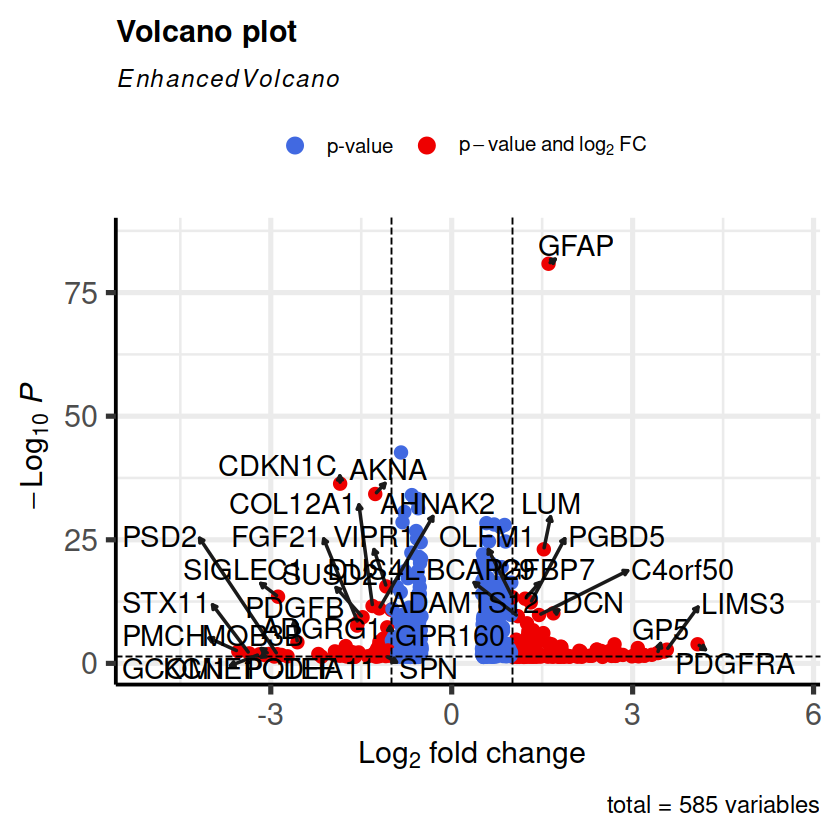

In [22]:
library(EnhancedVolcano)
### Bipolar Disorder
res <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/Drug_enriched_vs_NoDrug_log2FC_0.5.csv", sep=",", header=T, check.names=T, row.names=1)
ggsave("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/volcano/Drug_enriched_vs_NoDrug.png", width = 08, height = 08, units = "in", dpi = 300)
EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlab = bquote(~Log[2]~ 'fold change'),
   pCutoff = 0.05,
    FCcutoff = 1.0,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha = 1,
    legendPosition = 'top', ## can change to top, right, left, bottom and none
    legendLabSize = 12,
    legendIconSize = 4.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75,
                max.overlaps = 70) # Increased to show more labels
dev.off()

In [2]:
##### for the Yang's Dataset, apply the cluster signature to see the enrichment ########
#### The GSEA and ssGSEA approach both way and plot them as well ######


In [5]:
### Load the libraries ####
library(tidyverse)
library(GSEABase)
library(readr)
library(tidyverse)
library(dplyr)
# load the entire dataframe of all protein coding genes against which you want the gene expression
### the whole Dataset #####
exp_tbl <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv", header= T)

get_ssgsea_table <- function(X, gene_sets) {
  if (is.data.frame(X)) {
    X <- X %>%
      tibble::column_to_rownames(colnames(.)[[1]]) %>%
      as.data.frame() %>%
      as.matrix()
  }
  stopifnot(!any(duplicated(rownames(X))), is.numeric(X))
  
  # Remove genes w/constant expression
  #gene_sdev <- apply(X, MARGIN = 1, FUN = stats::sd)
  #X <- X[gene_sdev != 0, , drop = FALSE]
  
  set.seed(1)
  ssgsea_tab <- GSVA::gsva(expr = X, gset.idx.list = gene_sets,
                           method = 'ssgsea', kcdf = "Gaussian",
                           verbose=FALSE) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column(var = "sample_id") %>%
    tibble::as_tibble()

  return(ssgsea_tab)
}
# Applying ATAC cluster signature #####
geneSets <- getGmt("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/ATAC_cluster_signature.gmt") # .txt can works as well
## tips to make this 
# open excel sheet, paste the gene name in column, after that add two column in the begining, name the first column as liver like or whatever and name the secind column as NA and save this as a .txt file
newtable4 <- get_ssgsea_table(X = exp_tbl, gene_sets = geneSets)
## saving the results 
#write.table(newtable4, file="/data/SCLCgenomics/rajesh/ATAC_scripts/ATAC_analysis/ATAC_batch_1_2_3_quantified_peaks/RNA_data/pdx.rank3.rna/updated_sample_results/stemness_PNAS_paper_desktop_ssGSEA.tsv", sep="\t", row.names = FALSE)
## for cell line dataset
write.table(newtable4, file="/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/Yang_RNA_ATAC_signature_ssGSEA.tsv", sep="\t", row.names = FALSE)


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following obje

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [9]:
data <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/Yang_RNA_ATAC_signature_ssGSEA.tsv", sep='\t', header=T)
print(data)

     sample_id Cluster1_ATAC Cluster2_ATAC Cluster3_ATAC Disease
1  H446AM78241    0.07208425     0.7912927   -0.07868433    Drug
2  H446AM78242    0.07113948     0.7906842   -0.06831146    Drug
3 H446ANodrug3    0.07518032     0.7845044   -0.11289223  NoDrug
4 H446ANodrug1    0.07132140     0.7712567   -0.09212263  NoDrug
5 H446ANodrug2    0.07900306     0.7716074   -0.07964268  NoDrug
6  H446AM78243    0.08144143     0.8108021   -0.09220331    Drug
7    H446ATGF1    0.10343170     0.8293112   -0.15720562     TGF
8    H446ATGF2    0.13323455     0.8319723   -0.16802765     TGF
9    H446ATGF3    0.11591581     0.8263642   -0.15865492     TGF


In [10]:
#### Figure Generation for the ssGSEA dataset ####
##### Berzin dataset the Figure Generation #######
library(ggplot2)
library(ggpubr)

# Load the data
data <- read.table("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/Yang_RNA_ATAC_signature_ssGSEA.tsv", sep='\t', header=TRUE)

# Ensure Disease is a factor with the correct order
data$Disease <- factor(data$Disease, levels = c("Drug", "NoDrug", "TGF"))

# List of variables to plot and their new labels
vars_to_plot <- c("Cluster1_ATAC", "Cluster2_ATAC", "Cluster3_ATAC")
new_labels <- c("Cluster1 sig", "Cluster2 sig", "Cluster3 sig")

# Create and save individual plots
for (i in seq_along(vars_to_plot)) {
  var <- vars_to_plot[i]
  new_label <- new_labels[i]
  
  p <- ggboxplot(data, x = "Disease", y = var, 
                 fill = "Disease", 
                 palette = c("blue", "red", "purple"),
                 add = "jitter") +
    theme_classic2() + 
    stat_compare_means(comparisons = list(c("Drug", "NoDrug"), 
                                          c("Drug", "TGF"), 
                                          c("NoDrug", "TGF")),
                       method = "wilcox.test",
                       label = "p.signif", textsize = 5) +
    theme(
      text = element_text(family = "Arial", color = "black"),
      axis.title = element_text(face = "bold", size = 20, color = "black"),
      axis.text = element_text(face = "bold", size = 20, color = "black"),
      axis.text.x = element_text(angle = 0, hjust = 0.5),
      legend.position = "none",
      axis.title.x = element_blank(),
      strip.text = element_text(face = "bold"),
      axis.ticks.x = element_blank()
    ) +
    labs(x = NULL, y = new_label)
  
  # Save individual plot
  ggsave(filename = paste0("/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/", new_label, ".tiff"), 
         plot = p, width = 4, height = 4, units = "in", dpi = 300)
}


In [8]:
##### GSEA for Yangs Dataset for each samples and for each gene set ####
library(fgsea)
library(data.table)
library(tidyverse)
library(clusterProfiler)

# Input file paths
data_file <- "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/all_rna_seq.protein.coding_unique.tsv"
metadata_file <- "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/metadata.tsv"
gmt_file <- "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA/ATAC_cluster_signature.gmt"
output_dir <- "/data/kumarr9/X202SC24118381-Z01-F001/DGE_modified/GSEA"

# Load data
df <- read.table(data_file, sep="\t", header=TRUE, check.names=FALSE, row.names=1)
metadata <- read_tsv(metadata_file, show_col_types = FALSE)

# Load pathways from .gmt file
pathways <- gmtPathways(gmt_file)

# Define diseases
diseases <- unique(metadata$Disease)

# Function to safely calculate t-statistic
safe_t_test <- function(x, group1, group2) {
  tryCatch({
    if (sd(x) == 0) return(0)  # Return 0 if data is constant
    t.test(x[group1], x[group2])$statistic
  }, error = function(e) {
    return(0)  # Return 0 if t-test fails
  })
}

# Loop over diseases
for (disease in diseases) {
  # Define disease samples and comparison samples
  disease_samples <- metadata$ID[metadata$Disease == disease]
  other_samples <- metadata$ID[metadata$Disease != disease]

  # Ensure all samples in df
  all_samples <- intersect(colnames(df), c(disease_samples, other_samples))
  df_subset <- df[, all_samples]
  
  disease_samples <- intersect(disease_samples, all_samples)
  other_samples <- intersect(other_samples, all_samples)

  # Calculate t-statistics for each gene
  gene_stats <- apply(df_subset, 1, safe_t_test, group1 = disease_samples, group2 = other_samples)

  # Create a named ranking vector
  ranks <- sort(setNames(gene_stats, rownames(df_subset)), decreasing = TRUE)

  # Save the ranking file
  rank_file <- file.path(output_dir, paste0("ranks_", disease, ".rnk"))
  write.table(data.frame(gene=names(ranks), rank=ranks), file = rank_file, sep = "\t", col.names = FALSE, quote = FALSE, row.names = FALSE)

  # Perform GSEA for each gene set in the pathways
  for (gene_set in names(pathways)) {
    # Run fgsea
    fgsea_res <- fgsea(
      pathways = list(gene_set = pathways[[gene_set]]),
      stats = ranks,
      nperm = 1000,
      minSize = 2,
      maxSize = 500
    )

    # Sort results by p-value
    fgsea_res <- fgsea_res[order(fgsea_res$pval), ]

    # Save the GSEA results to a file
    gsea_file <- file.path(output_dir, paste0("fgsea_", disease, "_", gsub(" ", "_", gene_set), ".tsv"))
    fwrite(fgsea_res, file = gsea_file, sep = "\t")

    # Generate enrichment plot
    enrichment_plot <- plotEnrichment(pathways[[gene_set]], stats = ranks) +
      labs(
        title = paste("ENRICHMENT FOR", gene_set, "in", disease),
        x = "RANK IN PRERANKED GENE LIST",
        y = "RUNNING ENRICHMENT SCORE"
      ) +
      theme_classic(base_family = "Arial") +
      theme(
        plot.title = element_text(size = 18, face = "bold", color = "black"),
        axis.title.x = element_text(size = 18, face = "bold", color = "black"),
        axis.title.y = element_text(size = 18, face = "bold", color = "black"),
        axis.text = element_text(size = 18, face = "bold", color = "black"),
        legend.title = element_text(size = 18, face = "bold", color = "black"),
        legend.text = element_text(size = 18, face = "bold", color = "black")
      )

    # Save the plot as a TIFF file
    tiff_file <- file.path(output_dir, paste0("enrichment_plot_", disease, "_", gsub(" ", "_", gene_set), ".tiff"))
    ggsave(tiff_file, enrichment_plot, width = 8, height = 6, device = "tiff")
  }
}



Warning message in fgsea(pathways = list(gene_set = pathways[[gene_set]]), stats = ranks, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (9.61% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = list(gene_set = pathways[[gene_set]]), stats = ranks, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (9.61% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
